In [70]:
import numpy as np
import matplotlib.pyplot as plt
import yasa
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from sklearn.metrics import accuracy_score

Using default location ~/mne_data for PHYSIONET_SLEEP...
['/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

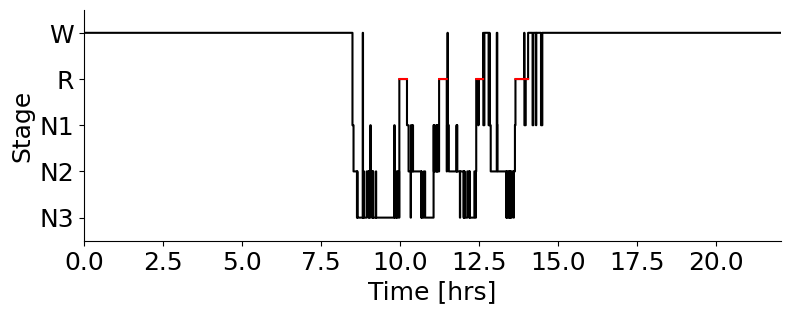

In [71]:
[alice_files] = fetch_data(subjects=[0], recording=[1])
print(alice_files)

edf = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot = mne.read_annotations(alice_files[1])

edf.set_annotations(annot, emit_warning=False)

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

events, _ = mne.events_from_annotations(
    edf, event_id=annotation_desc_2_event_id, chunk_duration=30.)

tmax = 30. - 1. / edf.info['sfreq']

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

epochs_test = mne.Epochs(raw=edf, events=events, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

hypno = epochs_test.events[:, 2] - 1

In [72]:
sls = yasa.SleepStaging(edf, eeg_name="EEG Fpz-Cz")
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)

csv_pre = pd.DataFrame(hypno_pred)
csv_pre.to_csv("./csv_pre.csv")

W→N2,W→N3の状態遷移を取り除く

In [73]:
# 指定した配列番号以降の配列が 0, 2 ... と並んでいることが前提
def check_trans(array, index, current, count):
    count += 1
    pos = array[index + 1]
    if pos == 0:
        return [True, index, count - 1]
    elif pos != 0 and pos != current:
        return [False, index, count - 1]
    elif pos == current:
        return check_trans(array, index + 1, current, count)
'''
    if array[index + 1] == 0:
        return [index + 1, 0]
    elif array[index + 1] != 0:
        return [index + 1, 1]
    elif array[index + 1] == current:
        return check_trans(array, index + 1, current)
'''


'\n    if array[index + 1] == 0:\n        return [index + 1, 0]\n    elif array[index + 1] != 0:\n        return [index + 1, 1]\n    elif array[index + 1] == current:\n        return check_trans(array, index + 1, current)\n'

In [74]:
hypno_fixed = np.copy(hypno_pred)
#hypno_pred = np.array([0,0,0,2,2,0,0,2,3,0])
hypno_fixed = np.copy(hypno_pred)
size = hypno_fixed.shape[0]
count = 0
res = [False, 0, 0]
for i in range(size - 1):
    if hypno_fixed[i] == 0 and hypno_fixed[i + 1] == 2:
        res = check_trans(hypno_fixed, i, 2, count)
        print(i, res)
    if res[0] and res[2] != 0:
        hypno_fixed[i + 1] = 0
        res[2] -= 1
    if res[2] == 0:
        res[0] = False
print(hypno_fixed)

csv_aft = pd.DataFrame(hypno_fixed)
csv_aft.to_csv("./csv_aft.csv")

136 [True, 137, 1]
214 [True, 215, 1]
320 [True, 321, 1]
396 [True, 397, 1]
507 [True, 509, 2]
508 [True, 509, 1]
511 [True, 512, 1]
542 [True, 547, 5]
543 [True, 547, 4]
544 [True, 547, 3]
545 [True, 547, 2]
546 [True, 547, 1]
559 [True, 560, 1]
594 [False, 595, 1]
601 [True, 602, 1]
607 [True, 608, 1]
618 [True, 619, 1]
699 [True, 700, 1]
752 [True, 753, 1]
978 [False, 979, 1]
1254 [True, 1257, 3]
1255 [True, 1257, 2]
1256 [True, 1257, 1]
1258 [False, 1266, 8]
1385 [False, 1389, 4]
1401 [False, 1405, 4]
1419 [False, 1428, 9]
1570 [True, 1576, 6]
1571 [True, 1576, 5]
1572 [True, 1576, 4]
1573 [True, 1576, 3]
1574 [True, 1576, 2]
1575 [True, 1576, 1]
1577 [True, 1588, 11]
1578 [True, 1588, 10]
1579 [True, 1588, 9]
1580 [True, 1588, 8]
1581 [True, 1588, 7]
1582 [True, 1588, 6]
1583 [True, 1588, 5]
1584 [True, 1588, 4]
1585 [True, 1588, 3]
1586 [True, 1588, 2]
1587 [True, 1588, 1]
1589 [True, 1591, 2]
1590 [True, 1591, 1]
1592 [False, 1604, 12]
1640 [True, 1641, 1]
1770 [False, 1774, 4]


ヒプノグラムの表示

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

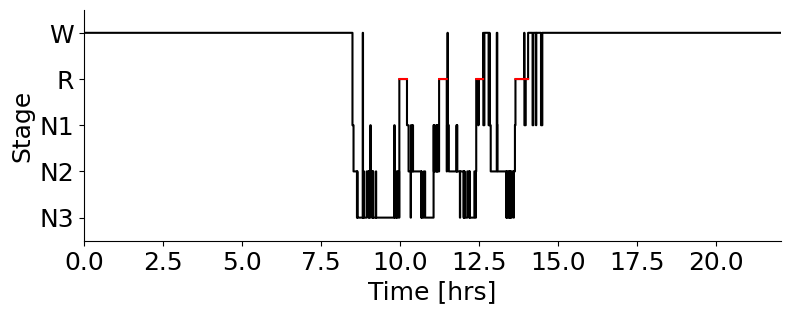

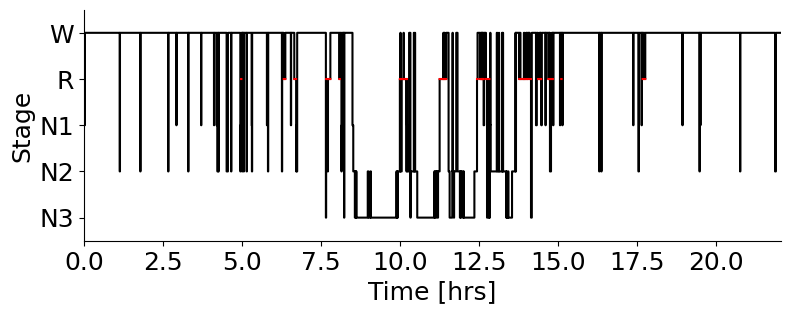

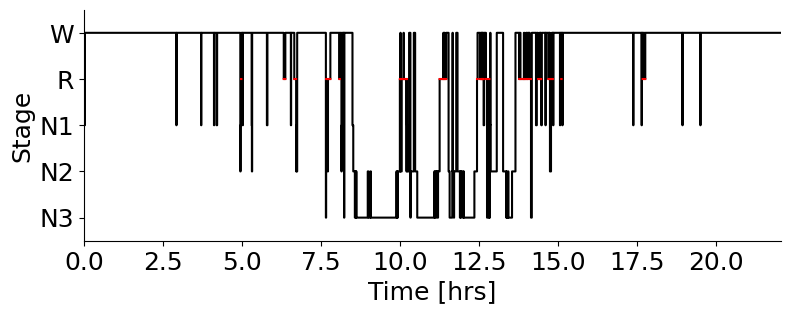

In [79]:
yasa.plot_hypnogram(hypno)
yasa.plot_hypnogram(hypno_pred)
yasa.plot_hypnogram(hypno_fixed)

In [78]:
acc_bef = accuracy_score(hypno, hypno_pred)
acc_aft = accuracy_score(hypno, hypno_fixed)
print('正確率')
print('  修正前', acc_bef)
print('  修正後', acc_aft)

正確率
  修正前 0.870188679245283
  修正後 0.8724528301886793
